In [13]:
import numpy as np
import matplotlib.pyplot as plt

### With this code I do the numerical simulation for the tent map and upside-down tent map in combination with learning by average. It also gives multiple graphs which can be used to give information about the dynamics.

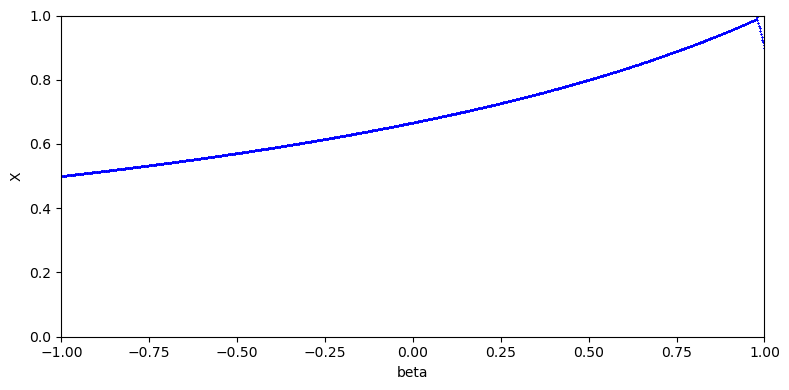

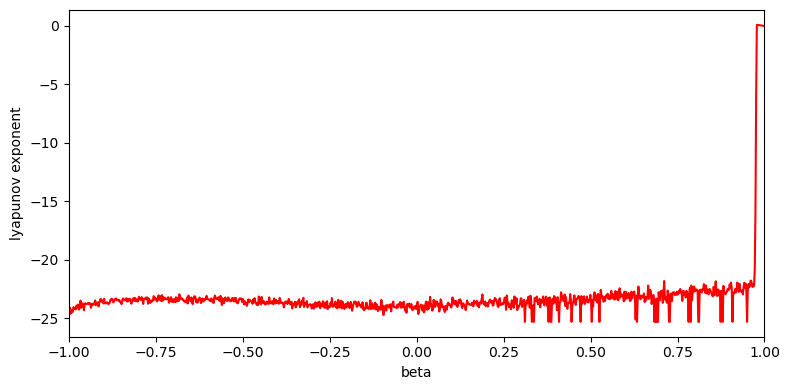

In [121]:
# Define the asymmetric tent map
def tent_map_scalar(x, beta):
    if x <= (1 + beta) / 2 and x >= 0:
        return 2 * x / (1 + beta)
    elif x > (1 + beta) / 2 and x <= 1:
        return 2 * (1 - x) / (1 - beta)
    elif x < 0:
        return 0
    else:
        return 1

def tent_map_scalar_ud(x, beta):
    return 1 - tent_map_scalar(x, beta)

def learning_by_average_forecast(x, t):
    x_known = x[:(t - 1)]
    return np.mean(x_known)

# Simulate the system under learning by average
def simulate_learning_by_average(beta, x0, tent, T=1000, burn_in=200):
    x_vals = np.zeros(T)
    forecast_vals = np.zeros(T + 1)
    x_vals[0] = x0
    if tent=="tent":
        for t in range(1, T):
            forecast_vals[t + 1] = learning_by_average_forecast(x_vals, t + 1)
            x_vals[t] = tent_map_scalar(forecast_vals[t + 1], beta)
    elif tent=="tent_ud":
        for t in range(1, T):
            forecast_vals[t + 1] = learning_by_average_forecast(x_vals, t + 1)
            x_vals[t] = tent_map_scalar_ud(forecast_vals[t + 1], beta)
    else:
        return False
    # Do not include the first 200 values
    return x_vals[burn_in:], forecast_vals

def lyapunov_exponent_learning_average(beta, x0, tent, T=5000, burn_in=1000, eps=1e-9):
    x_base, _ = simulate_learning_by_average(beta, x0, tent, T=T, burn_in=0)
    x_pert, _ = simulate_learning_by_average(beta, x0 + eps, tent, T=T, burn_in=0)
    dist = np.abs(x_pert - x_base) + 1e-20
    return np.log(dist[burn_in:] / eps).mean()

def orbit_and_lyapunov_learning_by_average(seed, n_skip, n_iter, tent, step=0.001):
    beta_range = np.linspace(-1, 1, int(1/step))
    lyap = []
    fig1, ax1 = plt.subplots(figsize=(8, 4))
    for beta in beta_range:
        x_vals = simulate_learning_by_average(beta, seed, tent, T=n_iter + n_skip, burn_in=n_skip)[0]
        ax1.scatter(np.full_like(x_vals, beta), x_vals, s=0.75, color='blue', alpha=0.8, linewidths=0)
        lyap.append(lyapunov_exponent_learning_average(beta, seed, tent))
    ax1.set_xlim(-1, 1)
    ax1.set_ylim(0, 1)
    ax1.set_xlabel('beta')
    ax1.set_ylabel('X')
    plt.tight_layout()
    if tent=="tent":
        plt.savefig("Images/learning_by_average_orbit_diagram.png", dpi=300)
    elif tent=="tent_ud":
        plt.savefig("Images/learning_by_average_orbit_diagram_ud.png", dpi=300)
    plt.show()
    fig2, ax2 = plt.subplots(figsize=(8, 4))
    ax2.plot(beta_range, lyap, color='red')
    ax2.set_xlim(-1, 1)
    ax2.set_xlabel('beta')
    ax2.set_ylabel('lyapunov exponent')
    plt.tight_layout()
    if tent=="tent":
        plt.savefig("Images/learning_by_average_lyapunov.png", dpi=300)
    elif tent=="tent_ud":
        plt.savefig("Images/learning_by_average_lyapunov_ud.png", dpi=300)
    plt.show()

orbit_and_lyapunov_learning_by_average(0.9, 5000, 50, "tent", step=0.001)

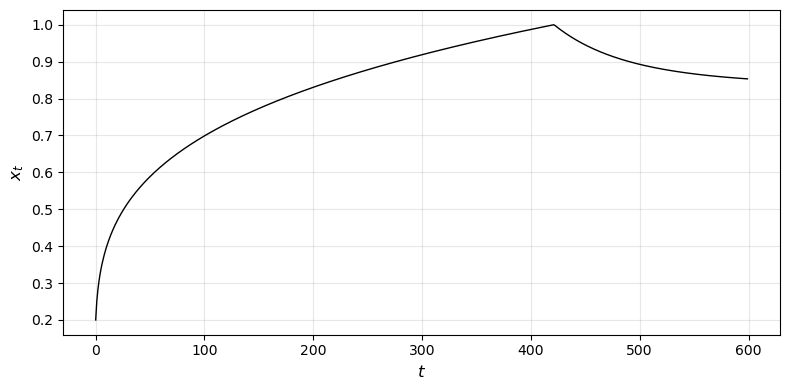

In [107]:
x = simulate_learning_by_average(beta=0.6, x0=0.2, tent="tent", T = 600, burn_in=0)[0]

def plot_time_series(x, tent):
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(x)), x, color='black', linewidth=1)
    plt.xlabel("$t$", fontsize=12)
    plt.ylabel("$x_t$", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if tent=="tent":
        plt.savefig("Images/learning_by_average_time_series.png")
    elif tent=="tent_ud":
        plt.savefig("Images/learning_by_average_time_series_ud.png")
    else:
        return False
    plt.show()

plot_time_series(x, "tent")

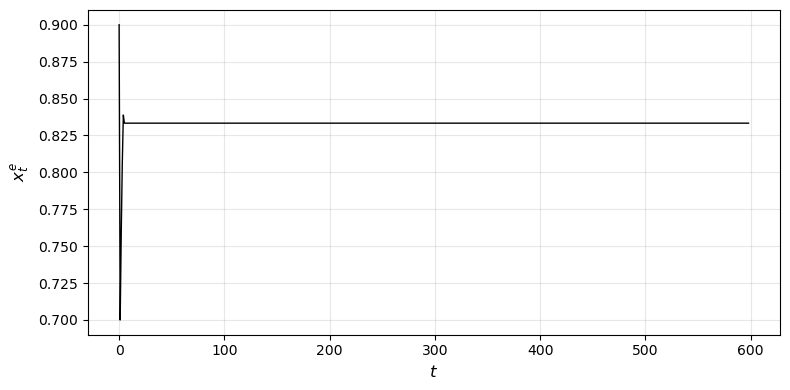

In [133]:
# Here I plot the predicted values over time, in this case the sample mean of past values
forecast_vals = simulate_learning_by_average(beta=0.6, x0=0.9, tent="tent", T = 600, burn_in=0)[1]

def plot_forecast_vals(x, tent):
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(x)), x, color='black', linewidth=1)
    plt.xlabel("$t$", fontsize=12)
    plt.ylabel("$x^e_t$", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if tent=="tent":
        plt.savefig("Images/learning_by_average_forecast_vals.png")
    elif tent=="tent_ud":
        plt.savefig("Images/learning_by_average_forecast_vals_ud.png")
    else:
        return False
    plt.show()

plot_forecast_vals(forecast_vals[2:], "tent")

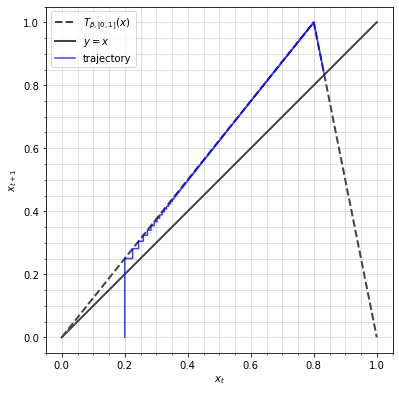

In [132]:
def tent_map(x, beta):
    x_arr   = np.asarray(x)
    thresh  = (1 + beta) / 2
    below   = 2 * x_arr / (1 + beta)
    above   = 2 * (1 - x_arr) / (1 - beta)
    return np.where(x_arr <= thresh, below, above)

def tent_map_ud(x, beta):
    return 1 - tent_map(x, beta)

dpi = 72

def plot_cobweb_learning_average(beta, x0, tent, n_iters=40,
                                 fname=None, figsize=(600, 450)):
    m_vals = []
    x_vals = [x0] 
    if tent=="tent":
        for _ in range(n_iters):
            m_next = np.mean(x_vals)
            m_vals.append(m_next)
            
            x_next  = tent_map_scalar(m_vals[-1], beta)    
            x_vals.append(x_next)
    elif tent=="tent_ud":
        for _ in range(n_iters):
            m_next = np.mean(x_vals)
            m_vals.append(m_next)
            
            x_next  = tent_map_scalar_ud(m_vals[-1], beta)    
            x_vals.append(x_next)
    else:
        return False

    px, py = [m_vals[0]], [0]
    for i in range(n_iters - 1):
        px.append(m_vals[i])
        py.append(x_vals[i+1])

        px.append(m_vals[i+1])
        py.append(x_vals[i+1])

    x_plot = np.linspace(0, 1, 500)

    fig = plt.figure(figsize=(figsize[0]/dpi, figsize[1]/dpi), dpi=dpi)
    ax  = fig.add_subplot(111)

    if tent=="tent":
        ax.plot(x_plot, tent_map(x_plot, beta),  c='#444444', lw=2,
                label=r'$T_{\beta, [0, 1]}(x)$', linestyle='--')
    elif tent=="tent_ud":
        ax.plot(x_plot, tent_map_ud(x_plot, beta),  c='#444444', lw=2,
                label=r'$\hat{T}_{\beta, [0, 1]}(x)$', linestyle='--')
    else:
        return False
    ax.plot(x_plot, x_plot, c='#444444', lw=2, label=r'$y=x$')

    ax.plot(px, py, c='b', alpha=0.75, label='trajectory')

    ax.set_aspect('equal')
    ax.minorticks_on()
    ax.grid(which='both', alpha=0.5)
    ax.set_xlabel(r'$x_t$')
    ax.set_ylabel(r'$x_{t + 1}$')
    ax.legend(loc='best')

    if tent=="tent":
        plt.savefig("Images/learning_by_average_cobweb.png")
    elif tent=="tent_ud":
        plt.savefig("Images/learning_by_average_cobweb_ud.png")
    else:
        return False

beta = 0.60
x0   = 0.20
plot_cobweb_learning_average(beta, x0, tent="tent", n_iters=1000)

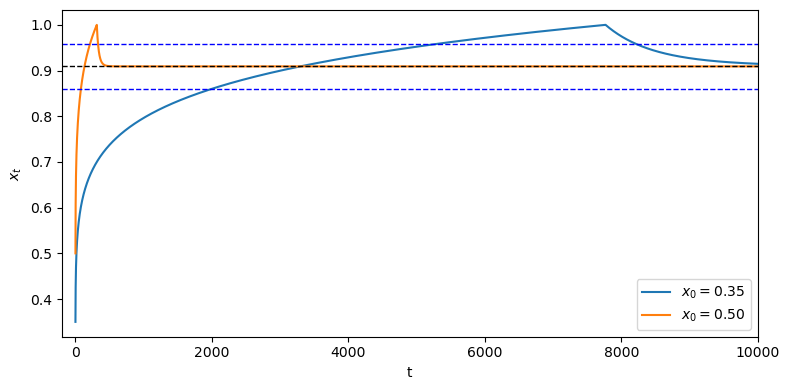

In [112]:
beta = 0.8
epsilon = 0.05
x_fixed = 2 / (3 - beta)
x_fixed_upper_bound = x_fixed + epsilon
x_fixed_lower_bound = x_fixed - epsilon
T = 10000

traj1, _ = simulate_learning_by_average(beta, 0.35, "tent", T=(T + 100), burn_in=0)
traj2, _ = simulate_learning_by_average(beta, 0.50, "tent", T=(T + 100), burn_in=0)

plt.figure(figsize=(8, 4))
plt.plot(traj1, label=r'$x_0=0.35$')
plt.plot(traj2, label=r'$x_0=0.50$')
plt.axhline(x_fixed, color='k', linestyle='--', linewidth=1)
plt.axhline(x_fixed_upper_bound, color='blue', linestyle='--', linewidth=1)
plt.axhline(x_fixed_lower_bound, color='blue', linestyle='--', linewidth=1)
plt.xlabel('t')
plt.ylabel(r'$x_t$')
plt.xlim(-200, T)
plt.legend()
plt.tight_layout()
plt.savefig('Images/conv_speed_beta_0_9.png', dpi=300)
plt.show()

### Now we go over to the upside-down tent map, again in combination with learning by average

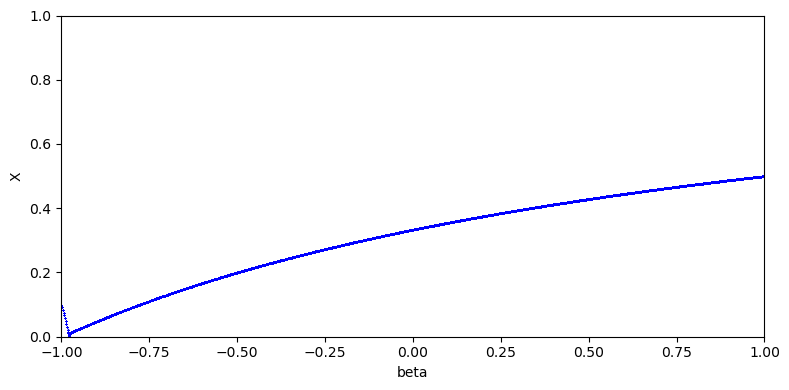

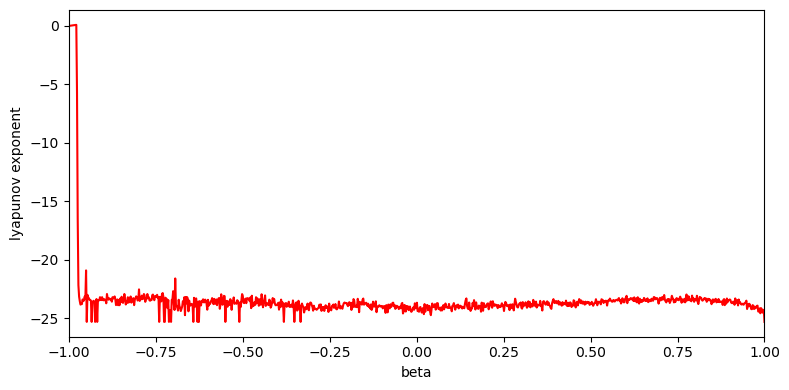

In [122]:
orbit_and_lyapunov_learning_by_average(0.1, 5000, 500, "tent_ud", step=0.001)

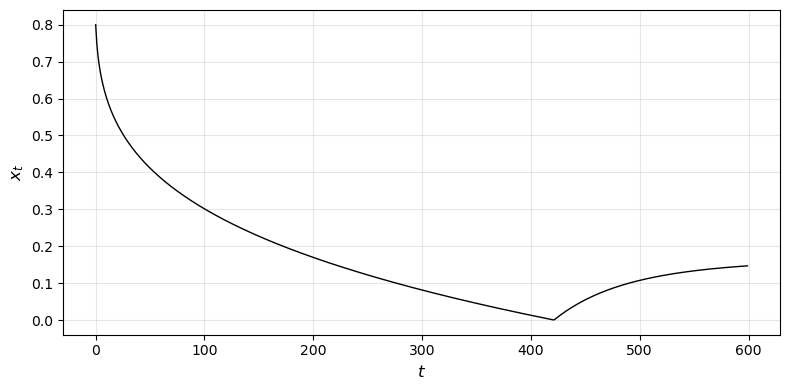

In [134]:
x = simulate_learning_by_average(beta=-0.6, x0=0.8, tent="tent_ud", T = 600, burn_in=0)[0]

plot_time_series(x, "tent_ud")

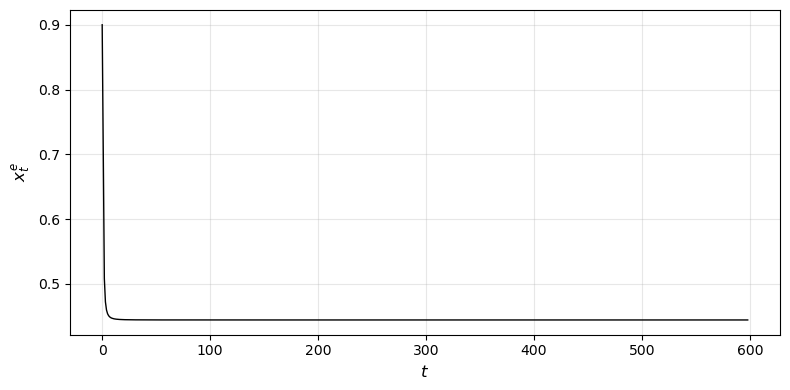

In [135]:
forecast_vals = simulate_learning_by_average(beta=0.6, x0=0.9, tent="tent_ud", T = 600, burn_in=0)[1]

plot_forecast_vals(forecast_vals[2:], "tent_ud")

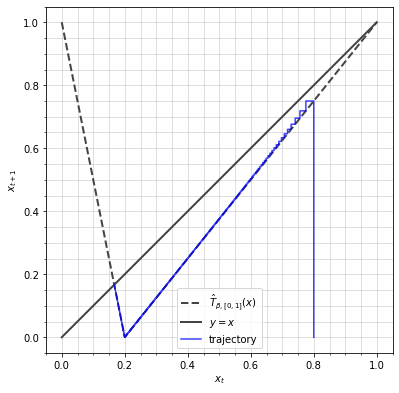

In [117]:
beta = -0.60
x0   = 0.80
plot_cobweb_learning_average(beta, x0, tent="tent_ud", n_iters=1000)